# ENV/ATM 415: Climate Laboratory

[Brian E. J. Rose](http://www.atmos.albany.edu/facstaff/brose/index.html), University at Albany

# Lecture 12: Transient warming: exploring the rate of climate change

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import climlab

So far in this class we have talked a lot about **Equilibrium Climate Sensitivity**: the surface warming that is necessary to bring the planetary energy budget back into balance (energy in = energy out) after a doubling of atmospheric CO2.

Although this concept is very important, it is not the only important measure of climate change, and not the only question for which we need to apply climate models.

Consider two basic facts about climate change in the real world:

- There is no sudden, abrupt doubling of CO2. Instead, CO2 and other radiative forcing agents change gradually over time.
- The timescale for adjustment to equilibrium is **very long** because of the heat capacity of the deep oceans.

We will now extend our climate model to deal with both of these issues simultaneously.

## Two versions of Radiative-Convective Equilibrium with different climate sensitivities

We are going to use the `BandRCModel` but set it up with two slightly different sets of parameters.

In [3]:
steps_per_year = 180
deltat = climlab.constants.seconds_per_year/steps_per_year

#  parameter set 1 -- store in a dictionary for easy re-use
p1 = {'albedo_sfc': 0.22,
      'adj_lapse_rate': 7.,
      'qStrat': 5E-6,
      'relative_humidity': 0.9}
#  parameter set 2
p2 = {'albedo_sfc': 0.171,
      'adj_lapse_rate': 6.,
      'qStrat': 5E-6,
      'relative_humidity': 0.6}
param = [p1, p2]

slab = []
for p in param:
    state = climlab.column_state(num_lev=30)
    h2o = climlab.radiation.ManabeWaterVapor(name='WaterVapor', 
                                state=state, 
                                relative_humidity=p['relative_humidity'],
                                qStrat=p['qStrat'],
                                timestep=deltat)
    rad = climlab.radiation.RRTMG(name='Radiation', 
                              state=state, 
                              specific_humidity=h2o.q, 
                              albedo=p['albedo_sfc'],
                              timestep=deltat,)
    conv = climlab.convection.ConvectiveAdjustment(name='Convection', 
                            state=state, 
                            adj_lapse_rate=p['adj_lapse_rate'],
                            timestep=deltat,)
    rcm = climlab.couple([h2o, rad, conv], name='Radiative-Convective Model')
    slab.append(rcm)

Getting ozone data from /Users/br546577/anaconda3/lib/python3.6/site-packages/climlab/radiation/data/ozone/apeozone_cam3_5_54.nc
Getting ozone data from /Users/br546577/anaconda3/lib/python3.6/site-packages/climlab/radiation/data/ozone/apeozone_cam3_5_54.nc


Run both models out to equilibrium and check their surface temperatures:

In [4]:
for model in slab:
    model.integrate_years(5)

print('The TOA energy imbalances are:')
print('Model 0: %0.5f W/m2' %(slab[0].ASR - slab[0].OLR))
print('Model 1: %0.5f W/m2' %(slab[1].ASR - slab[1].OLR))
print('The equilibrium surface temperatures are:')
print('Model 0: %0.2f K' %slab[0].Ts)
print('Model 1: %0.2f K' %slab[1].Ts)

Integrating for 900 steps, 1826.2110000000002 days, or 5 years.
Total elapsed time is 5.0 years.
Integrating for 900 steps, 1826.2110000000002 days, or 5 years.
Total elapsed time is 5.0 years.
The TOA energy imbalances are:
Model 0: -0.00002 W/m2
Model 1: 0.00000 W/m2
The equilibrium surface temperatures are:
Model 0: 287.57 K
Model 1: 287.67 K


Ok so our two models (by construction) start out with nearly identical temperatures.

Now we double CO2 and calculate the Equilibrium Climate Sensitivity:

In [5]:
#  We will make copies of each model and double CO2 in the copy
slab_2x = []
for model in slab:
    model_2x = climlab.process_like(model)
    model_2x.subprocess['Radiation'].absorber_vmr['CO2'] *= 2.
    model_2x.integrate_years(5)
    slab_2x.append(model_2x)

#  Climate sensitivity
DeltaT = []
for n in range(len(slab)):
    DeltaT.append(slab_2x[n].Ts - slab[n].Ts)
print('The equilibrium climate sensitivities are:')
print('Model 0: %0.2f K' %DeltaT[0])
print('Model 1: %0.2f K' %DeltaT[1])

Integrating for 900 steps, 1826.2110000000002 days, or 5 years.
Total elapsed time is 10.0 years.
Integrating for 900 steps, 1826.2110000000002 days, or 5 years.
Total elapsed time is 10.0 years.
The equilibrium climate sensitivities are:
Model 0: 2.54 K
Model 1: 2.16 K


So Model 0 is **more sensitive** than Model 1. It has a larger system gain, or a more positive overall climate feedback. 

This is actually due to differences in how we have parameterized the water vapor feedback in the two models. We could look at this more carefully if we wished.

## Time to reach equilibrium

These models reached their new equilibria in just a few years. Why is that? Because they have very little heat capacity:

In [6]:
slab[0].depth_bounds

array([ 0.,  1.])

The "ocean" in these models is just a "slab" of water 1 meter deep.

That's all we need to calculate the equilibrium temperatures, but it tells us nothing about the timescales for climate change in the real world.

For this, we need a deep ocean that can **exchange heat with the surface**.

## Transient warming scenarios in column models with ocean heat uptake

We are now going to build two new models. The atmosphere (radiative-convective model) will be identical to the two "slab" models we just used. But these will be coupled to a **column of ocean water** 2000 m deep!

We will **parameterize the ocean heat uptake** as a diffusive mixing process. Much like when we discussed the diffusive parameterization for atmospheric heat transport -- we are assuming that ocean dynamics result in a vertical mixing of heat from warm to cold temperatures.

The following code will set this up for us.

We will make one more assumption, just for the sake of illustration:

*The more sensitive model (Model 0) is also more efficent at taking up heat into the deep ocean*

In [9]:
#  Create the domains
ocean_bounds = np.arange(0., 2010., 100.)
depthax = climlab.Axis(axis_type='depth', bounds=ocean_bounds)
ocean = climlab.domain.domain.Ocean(axes=depthax)
atm = slab[0].Tatm.domain

#  Model 0 has a higher ocean heat diffusion coefficient -- 
#  a more efficent deep ocean heat sink
ocean_diff = [5.E-4, 3.5E-4]

#  List of deep ocean models
deep = []
for n in range(len(param)):
    #  Create the state variables
    Tinitial_ocean = slab[n].Ts * np.ones(ocean.shape)
    Tocean = climlab.Field(Tinitial_ocean.copy(), domain=ocean)
    Tatm = climlab.Field(slab[n].Tatm.copy(), domain=atm)

    #  Surface temperature Ts is the upper-most grid box of the ocean
    Ts = Tocean[0:1]
    atm_state = {'Tatm': Tatm, 'Ts': Ts}

    h2o = climlab.radiation.ManabeWaterVapor(name='WaterVapor', 
                                state=atm_state, 
                                relative_humidity=p['relative_humidity'],
                                qStrat=p['qStrat'],
                                timestep=deltat)
    rad = climlab.radiation.RRTMG(name='Radiation', 
                              state=atm_state, 
                              specific_humidity=h2o.q, 
                              albedo=p['albedo_sfc'],
                              timestep=deltat,)
    conv = climlab.convection.ConvectiveAdjustment(name='Convection', 
                            state=atm_state, 
                            adj_lapse_rate=p['adj_lapse_rate'],
                            timestep=deltat,)
    model = climlab.couple([h2o, rad, conv], 
                           name='Radiative-Convective Model with deep ocean')
    model.set_state('Tocean', Tocean)
    diff = climlab.dynamics.Diffusion(state={'Tocean': model.Tocean}, 
                                K=ocean_diff[n], 
                                diffusion_axis='depth', 
                                timestep=deltat,)
    model.add_subprocess('Ocean Heat Uptake', diff)
    deep.append(model)

print(deep[0])

Getting ozone data from /Users/br546577/anaconda3/lib/python3.6/site-packages/climlab/radiation/data/ozone/apeozone_cam3_5_54.nc
Getting ozone data from /Users/br546577/anaconda3/lib/python3.6/site-packages/climlab/radiation/data/ozone/apeozone_cam3_5_54.nc
climlab Process of type <class 'climlab.process.time_dependent_process.TimeDependentProcess'>. 
State variables and domain shapes: 
  Tatm: (30,) 
  Ts: (1,) 
  Tocean: (20,) 
The subprocess tree: 
Radiative-Convective Model with deep ocean: <class 'climlab.process.time_dependent_process.TimeDependentProcess'>
   WaterVapor: <class 'climlab.radiation.water_vapor.ManabeWaterVapor'>
   Radiation: <class 'climlab.radiation.rrtm.rrtmg.RRTMG'>
      SW: <class 'climlab.radiation.rrtm.rrtmg_sw.RRTMG_SW'>
      LW: <class 'climlab.radiation.rrtm.rrtmg_lw.RRTMG_LW'>
   Convection: <class 'climlab.convection.convadj.ConvectiveAdjustment'>
   Ocean Heat Uptake: <class 'climlab.dynamics.diffusion.Diffusion'>



Now consider the CO2 increase. In the real world, CO2 has been increasing every year since the beginning of industrialization. Future CO2 concentrations depend on collective choices made by human societies about how much fossil fuel to extract and burn.

We will set up a simple scenario. Suppose that CO2 increases by 1% of its existing concentration every year **until it reaches 2x its initial concentration**. This takes about 70 years.

After 70 years, we assume that all anthropogenic emissions, and CO2 concentration is **stabilized** at the 2x level.

What happens to the surface temperature?

How do the histories of surface and deep ocean temperature compare in our two models?

We are going to simulation **400 years of transient global warming** in the two models.

In [11]:
num_years = 400
years = np.arange(num_years+1)

Tsarray = []
Tocean = []
netrad = []
for n in range(len(param)):
    thisTs = np.nan * np.zeros(num_years+1)
    thisnetrad = np.nan * np.zeros(num_years+1)
    thisTocean = np.nan * np.zeros((deep[n].Tocean.size, num_years+1))
    thisTs[0] = deep[n].Ts
    thisnetrad[0] = deep[n].ASR - deep[n].OLR
    thisTocean[:, 0] = deep[n].Tocean
    Tsarray.append(thisTs)
    Tocean.append(thisTocean)
    netrad.append(thisnetrad)
    
CO2initial = deep[0].subprocess['Radiation'].absorber_vmr['CO2']
CO2array = np.nan * np.zeros(num_years+1)
CO2array[0] = CO2initial * 1E6

#  Increase CO2 by 1% / year for 70 years (until doubled), and then hold constant
for y in range(num_years):
    print(y)
    if deep[0].subprocess['Radiation'].absorber_vmr['CO2'] < 2 * CO2initial:
        for model in deep:
            model.subprocess['Radiation'].absorber_vmr['CO2'] *= 1.01
    CO2array[y+1] = deep[0].subprocess['Radiation'].absorber_vmr['CO2'] * 1E6

    for n, model in enumerate(deep):
        model.integrate_years(1, verbose=False)
        Tsarray[n][y+1] = deep[n].Ts
        Tocean[n][:, y+1] = deep[n].Tocean
        netrad[n][y+1] = deep[n].ASR - deep[n].OLR

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

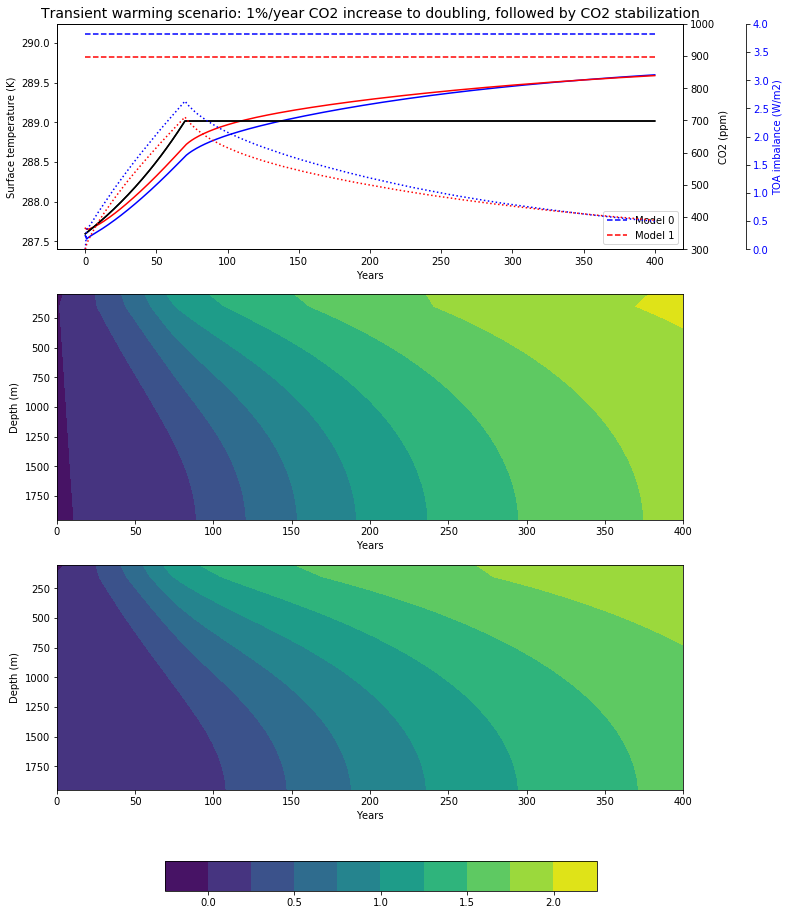

In [17]:
colorlist = ['b', 'r']
co2color = 'k'

num_axes = len(param) + 1
fig, ax = plt.subplots(num_axes, figsize=(12,14))

# Twin the x-axis twice to make independent y-axes.
topaxes = [ax[0], ax[0].twinx(), ax[0].twinx()]

# Make some space on the right side for the extra y-axis.
fig.subplots_adjust(right=0.85)

# Move the last y-axis spine over to the right by 10% of the width of the axes
topaxes[-1].spines['right'].set_position(('axes', 1.1))

# To make the border of the right-most axis visible, we need to turn the frame
# on. This hides the other plots, however, so we need to turn its fill off.
topaxes[-1].set_frame_on(True)
topaxes[-1].patch.set_visible(False)

for n, model in enumerate(slab_2x):
    topaxes[0].plot(model.Ts*np.ones_like(Tsarray[n]), '--', color=colorlist[n])
topaxes[0].set_ylabel('Surface temperature (K)')
topaxes[0].set_xlabel('Years')
topaxes[0].set_title('Transient warming scenario: 1%/year CO2 increase to doubling, followed by CO2 stabilization', fontsize=14)
topaxes[0].legend(['Model 0', 'Model 1'], loc='lower right')

topaxes[1].plot(CO2array, color=co2color)
topaxes[1].set_ylabel('CO2 (ppm)', color=co2color)
for tl in topaxes[1].get_yticklabels():
    tl.set_color(co2color)
topaxes[1].set_ylim(300., 1000.)

topaxes[2].set_ylabel('TOA imbalance (W/m2)', color='b')
for tl in topaxes[2].get_yticklabels():
    tl.set_color('b')
topaxes[2].set_ylim(0, 4)

for n, model in enumerate(deep):
    topaxes[0].plot(Tsarray[n], color=colorlist[n])
    topaxes[2].plot(netrad[n], ':', color=colorlist[n])
    for n in range(len(param)):
        cax = ax[n+1].contourf(years, deep[n].depth, Tocean[n] - Tsarray[n][0], levels=contour_levels)    
topaxes[1].plot(CO2array, color=co2color)



contour_levels = np.arange(-0.25, 2.5, 0.25)
for n in range(len(param)):
    cax = ax[n+1].contourf(years, deep[n].depth, Tocean[n] - Tsarray[n][0], levels=contour_levels)
    ax[n+1].invert_yaxis()
    ax[n+1].set_ylabel('Depth (m)')
    ax[n+1].set_xlabel('Years')

fig.subplots_adjust(bottom=0.12)
cbar_ax = fig.add_axes([0.25, 0.02, 0.5, 0.03])
fig.colorbar(cax, cax=cbar_ax, orientation='horizontal');




In [ ]:
    # is it time to update the plots?
    plot_freq = 5
    if y%plot_freq == 0:
        for n, model in enumerate(deep):
            topaxes[0].plot(Tsarray[n], color=colorlist[n])
            topaxes[2].plot(netrad[n], ':', color=colorlist[n])
            for n in range(len(param)):
                cax = ax[n+1].contourf(years, deep[n].depth, Tocean[n] - Tsarray[n][0], levels=contour_levels)    
        topaxes[1].plot(CO2array, color=co2color)
        fig.canvas.draw()

In [108]:
#  This code will generate a 'live plot' showing the transient warming in the two models.
#  The figure will update itself after every 5 years of simulation

num_years = 400
years = np.arange(num_years+1)

Tsarray = []
Tocean = []
netrad = []
for n in range(len(param)):
    thisTs = np.nan * np.zeros(num_years+1)
    thisnetrad = np.nan * np.zeros(num_years+1)
    thisTocean = np.nan * np.zeros((deep[n].Tocean.size, num_years+1))
    thisTs[0] = deep[n].Ts
    thisnetrad[0] = deep[n].ASR - deep[n].OLR
    thisTocean[:, 0] = deep[n].Tocean
    Tsarray.append(thisTs)
    Tocean.append(thisTocean)
    netrad.append(thisnetrad)
    
CO2initial = deep[0].subprocess['Radiation'].absorber_vmr['CO2']
CO2array = np.nan * np.zeros(num_years+1)
CO2array[0] = CO2initial * 1E6

colorlist = ['b', 'r']
co2color = 'k'

num_axes = len(param) + 1
fig, ax = plt.subplots(num_axes, figsize=(12,14))

# Twin the x-axis twice to make independent y-axes.
topaxes = [ax[0], ax[0].twinx(), ax[0].twinx()]

# Make some space on the right side for the extra y-axis.
fig.subplots_adjust(right=0.85)

# Move the last y-axis spine over to the right by 10% of the width of the axes
topaxes[-1].spines['right'].set_position(('axes', 1.1))

# To make the border of the right-most axis visible, we need to turn the frame
# on. This hides the other plots, however, so we need to turn its fill off.
topaxes[-1].set_frame_on(True)
topaxes[-1].patch.set_visible(False)

for n, model in enumerate(slab_2x):
    topaxes[0].plot(model.Ts*np.ones_like(Tsarray[n]), '--', color=colorlist[n])
topaxes[0].set_ylabel('Surface temperature (K)')
topaxes[0].set_xlabel('Years')
topaxes[0].set_title('Transient warming scenario: 1%/year CO2 increase to doubling, followed by CO2 stabilization', fontsize=14)
topaxes[0].legend(['Model 0', 'Model 1'], loc='lower right')

topaxes[1].plot(CO2array, color=co2color)
topaxes[1].set_ylabel('CO2 (ppm)', color=co2color)
for tl in topaxes[1].get_yticklabels():
    tl.set_color(co2color)
topaxes[1].set_ylim(300., 1000.)

topaxes[2].set_ylabel('Radiative forcing (W/m2)', color='b')
for tl in topaxes[2].get_yticklabels():
    tl.set_color('b')
topaxes[2].set_ylim(0, 4)

contour_levels = np.arange(-1, 4.5, 0.25)
for n in range(len(param)):
    cax = ax[n+1].contourf(years, deep[n].depth, Tocean[n] - Tsarray[n][0], levels=contour_levels)
    ax[n+1].invert_yaxis()
    ax[n+1].set_ylabel('Depth (m)')
    ax[n+1].set_xlabel('Years')

fig.subplots_adjust(bottom=0.12)
cbar_ax = fig.add_axes([0.25, 0.02, 0.5, 0.03])
fig.colorbar(cax, cax=cbar_ax, orientation='horizontal');

#  Increase CO2 by 1% / year for 70 years (until doubled), and then hold constant
for y in range(num_years):
    if deep[0].subprocess['Radiation'].absorber_vmr['CO2'][0] < 2 * CO2initial:
        for model in deep:
            model.subprocess['Radiation'].absorber_vmr['CO2'] *= 1.01
    CO2array[y+1] = deep[0].subprocess['Radiation'].absorber_vmr['CO2'][0] * 1E6

    for n, model in enumerate(deep):
        model.integrate_years(1, verbose=False)
        Tsarray[n][y+1] = deep[n].Ts
        Tocean[n][:, y+1] = deep[n].Tocean
        netrad[n][y+1] = deep[n].ASR - deep[n].OLR
        
    # is it time to update the plots?
    plot_freq = 5
    if y%plot_freq == 0:
        for n, model in enumerate(deep):
            topaxes[0].plot(Tsarray[n], color=colorlist[n])
            topaxes[2].plot(netrad[n], ':', color=colorlist[n])
            for n in range(len(param)):
                cax = ax[n+1].contourf(years, deep[n].depth, Tocean[n] - Tsarray[n][0], levels=contour_levels)    
        topaxes[1].plot(CO2array, color=co2color)
        fig.canvas.draw()

<IPython.core.display.Javascript object>

TypeError: 'float' object is not subscriptable

## Transient vs. equilibrium warming: key points

- During the first 70 years, the radiative forcing goes up every year
- The warming in the two models is almost identical during this phase
- After year 70, the CO2 levels are stable and so the radiative forcing is no longer increasing
- Both models continue to warm for hundreds of years
- The difference between the two models become larger over time
- In either case, at the time of CO2 doubling the model has achieved only a fraction of its equilibrium surface warming.
- The difference between the warming at year 70 and the equilibrium warming is called the **committed warming**. It is the global warming associated with CO2 emissions that are **already in the atmosphere**.
- How do we know at year 70 what the committed warming is?  Are we on the blue or the red path? At year 70, have we achieved half or only a third of the eventual equilibrium warming?
- In our example, the more sensitive model also has more efficient ocean heat uptake, so the initial warming looks identical. 
- **Uncertainties in both climate feedback processes and ocean heat uptake processes contribute to uncertainty in the rate of global warming**